In [1]:
# Import và cài đặt thư viện
import pandas as pd
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup
import string
import numpy as np
import os
import glob

import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('punkt_tab')
from nltk.stem import WordNetLemmatizer

import wordcloud
from wordcloud import WordCloud, STOPWORDS
from textblob import Word
from collections import Counter

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.models import load_model


from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
# Đọc dữ liệu
train_df = pd.read_csv("../Data/train_data.csv", encoding = "ISO-8859-1")

In [3]:
stopwords_lstm = pd.read_csv('../Train_LSTM/stopwords_lstm.csv')

# Hàm tiền xử lý văn bản
def preprocess(text):

    # Lấy danh sách stopwords cơ bản
    stopwords = set(STOPWORDS)

    stopwords.update([str(i).lower() for i in stopwords_lstm.name])     # Thêm stopwords riêng về hàng không

    # Các regex để lọc văn bản
    mentions_filter = re.compile(r'(?<=\@)(\w+)')       # Lọc mentions (@username)

    hashtags_filter = re.compile(r'(?<=\#)(\w+)')       # Lọc hashtags (#hashtag)

    flight_numbers = re.compile(r'(flt\d*)')        # Lọc số hiệu chuyến bay (flt123)

    # Tìm các mentions, hashtags và số hiệu chuyến bay
    all_mentions = mentions_filter.findall(text.lower())
    all_hashtag = hashtags_filter.findall(text.lower())
    all_flights = flight_numbers.findall(text.lower())

    word_lemmatize = WordNetLemmatizer()        # Khởi tạo lemmatizer

    # Hàm lemmatize danh sách từ
    def lemm_tokens(tokens, lemmatize):
        lemmatized = []
        for item in tokens:
            lemmatized.append(lemmatize.lemmatize(item,'v'))    # Lemmatize động từ
        return lemmatized

    # Loại bỏ emoji (kí tự không ASCII)
    def deEmojify(inputString):
        return inputString.encode('ascii', 'ignore').decode('ascii')

    text = deEmojify(text)  # Xóa emoji
    soup = BeautifulSoup(text)  # Loại bỏ HTML tags
    text = soup.get_text()

    # Loại bỏ dấu câu
    punc_text = [x.lower() for x in text if x not in string.punctuation]
    text = "".join(punc_text)

    word_tokens = nltk.word_tokenize(text)      # Tokenize văn bản thành các từ

    filtered_tokens = [x for x in word_tokens if len(x)>2 and len(x)<15]    # Lọc từ quá ngắn hoặc dài

    tokens = lemm_tokens(filtered_tokens, word_lemmatize)       # Lemmatize từ

    # Loại bỏ stopwords, mentions, hashtags, flights, và số
    all_tokens = [i for i in tokens if (i not in stopwords) and (i not in all_mentions)
                  and (i not in all_hashtag) and (i not in all_flights) and (not i.isdigit())]

    return all_tokens

In [4]:
# Loại bỏ các dòng có giá trị text là NaN
train_df = train_df.dropna(subset=['text'])

In [5]:
# Áp dụng hàm tiền xử lý lên cột text
train_df['text_tokenized']=train_df['text'].astype("string").map(preprocess)

C:\Users\Admin\AppData\Local\Temp\ipykernel_17792\3609606662.py:37: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text)  # Loại bỏ HTML tags


In [6]:
# Đặt lại chỉ số
train_df = train_df.reset_index(drop=True)

In [7]:
# Hàm loại bỏ dòng có cột 'text_tokenized' rỗng
def remove_if_empty(df):
    empty_ids = df['text_tokenized'].map(lambda i: len(i)) > 0
    idsToDelete = []
    for i in range(len(empty_ids)):
        if not empty_ids[i]:
            idsToDelete.append(i)
    for currentID in idsToDelete:
        df = df.drop(df[df.index == currentID].index[0])
    return df

In [8]:
from tensorflow.keras.layers import Bidirectional

# Gán nhãn dạng số cho cột airline_sentiment
lb=LabelEncoder()
train_df['airline_sentiment'] = lb.fit_transform(train_df['airline_sentiment'])

# Tokenize văn bản thành chuỗi số nguyên
tokenizer = Tokenizer(num_words=2000, split=' ')
tokenizer.fit_on_texts(train_df['text_tokenized'].values)  # Fit tokenizer
X = tokenizer.texts_to_sequences(train_df['text'].values)  # Chuyển văn bản sang chuỗi số
X = pad_sequences(X)  # Đệm để có cùng chiều dài

# Xây dựng mô hình tuần tự
model = Sequential()
model.add(Embedding(2000, 128, input_length=X.shape[1]))  # Lớp embedding
model.add(SpatialDropout1D(0.4))  # Dropout không gian để giảm overfitting
model.add(Bidirectional(LSTM(196, dropout=0.2, recurrent_dropout=0.2)))  # LSTM hai chiều
model.add(Dense(3, activation='softmax'))  # Lớp đầu ra với 3 nhãn
model.build(input_shape=(None, X.shape[1]))  # Định nghĩa hình dạng input
model.compile(loss='categorical_crossentropy', optimizer='adamw', metrics=['accuracy'])  # Biên dịch mô hình

print(model.summary())

# Chuyển nhãn y thành one-hot encoding
y=pd.get_dummies(train_df['airline_sentiment'])
# Chia dữ liệu train/test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

# Huấn luyện mô hình
batch_size=32
model.fit(X_train, y_train, epochs = 50, validation_data = (X_test, y_test),batch_size=batch_size, verbose = 'auto')
model.evaluate(X_test,y_test)   # Đánh giá mô hình trên tập test

e:\2024_2025_HK1\TLCN\telekafka\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 28, 128)        │       256,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 28, 128)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 392)            │       509,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         1,179 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 766,779 (2.93 MB)

 Trainable params: 766,779 (2.93 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
743/743 ━━━━━━━━━━━━━━━━━━━━ 25s 30ms/step - accuracy: 0.5884 - loss: 0.9183 - val_accuracy: 0.6621 - val_loss: 0.7641
Epoch 2/50
743/743 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.6899 - loss: 0.7196 - val_accuracy: 0.6957 - val_loss: 0.7097
Epoch 3/50
743/743 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - accuracy: 0.7282 - loss: 0.6424 - val_accuracy: 0.7078 - val_loss: 0.6957
Epoch 4/50
743/743 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.7571 - loss: 0.5916 - val_accuracy: 0.7146 - val_loss: 0.6836
Epoch 5/50
743/743 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.7720 - loss: 0.5593 - val_accuracy: 0.7260 - val_loss: 0.6630
Epoch 6/50
743/743 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - accuracy: 0.7841 - loss: 0.5257 - val_accuracy: 0.7388 - val_loss: 0.6588
Epoch 7/50
743/743 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - accuracy: 0.7929 - loss: 0.5025 - val_accuracy: 0.7410 - val_loss: 0.6548
Epoch 8/50
743/743 ━━━━━━━━━━━━━━━━━━━━ 25s 33ms/step - accuracy: 0.8118 - loss: 0.45

[0.9931632280349731, 0.7995624542236328]

In [9]:
# Lưu cấu trúc và trọng số mô hình
from pathlib import Path

folder_path = Path("LSTM/LSTM_details")
folder_path.mkdir(parents=True, exist_ok=True)     # Tạo thư mục nếu chưa có

model_structure = model.to_json()   # Lưu cấu trúc mô hình
f = folder_path / "model_structure_bi.json"
f.write_text(model_structure)


model.save_weights(folder_path / "model_weights_bi.weights.h5")  # Lưu trọng số mô hình
model.save(folder_path / 'model_bi.h5')  # Lưu mô hình đầy đủ

# Lưu độ dài tối đa chuỗi
max_length = str(len(X_train[0]))
f = folder_path / "X_train_max_length_bi.txt"
f.write_text(max_length)

# Lưu tokenized text
train_df = train_df.reset_index(drop=True)
train_df[['text_tokenized']].to_csv(folder_path / "train_text_vals_bi.csv")



186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


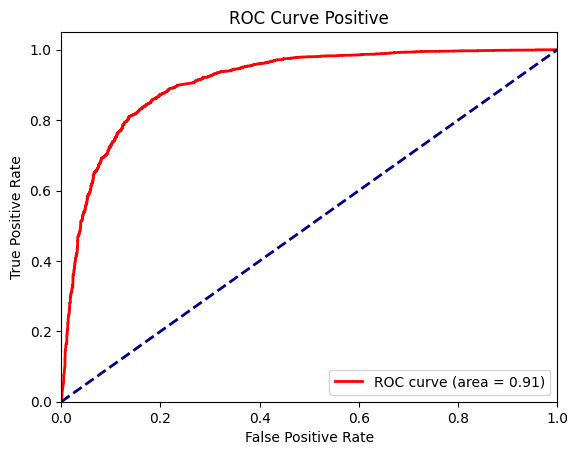

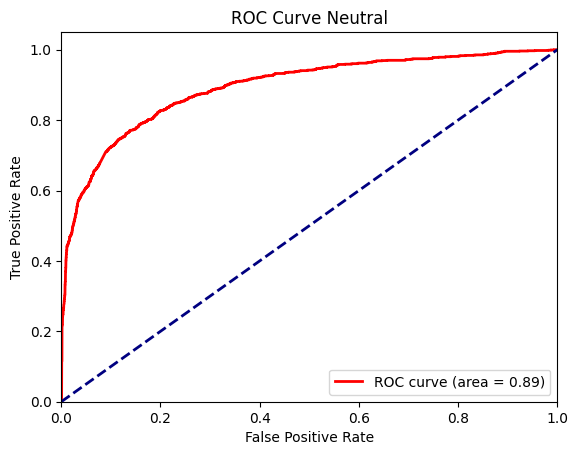

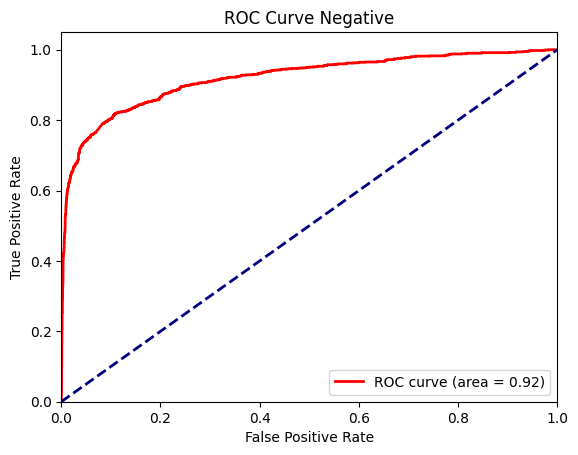

In [10]:
# Vẽ biểu đồ ROC
from sklearn.metrics import roc_curve, auc

fpr, tpr, roc_auc = {}, {}, {}

y_test = y_test.to_numpy()
y_score = model.predict(X_test)

label = ['Positive','Neutral','Negative']
n_classes = 3

# Tính và vẽ đường cong ROC
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Vẽ ROC cho từng lớp
for nc in range(3):
    plt.figure()
    plt.plot( fpr[nc], tpr[nc],
        color="red", lw=2, label="ROC curve (area = %0.2f)" % roc_auc[nc])
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve "+label[nc])
    plt.legend(loc="lower right")
    plt.show()